### UTILIZACION DE CONVNETS PREENTRENADAS PARA CLASIFICACION DOGS VS CATS


Una red preentrenada es una red guardada que se ha entrenado con anterioridad en un conjunto de datos grandes, por lo general en una tarea de clasificacion de imagenes a gran escala. Si este conjunto de datos original es lo bastantes grande y general, entonces ,la jerarquia espacial de caracteristicas aprendida por la red preentrenada puede actuar de manera efectiva como modelo generico del mundo visual y por tanto, sus caracteristicas pueden actual de manera efectiva como modelo generico del mundo visual y, por tanto, sus caracteristicas pueden resultar utiles para muchos problemas nuevos cuenten con clases completamente diferentes a las de la tarea original.

Por ejemplo, podriamos entrenar una red en Imagenet (donde las clases son, sobre todo, animales y objetos cotidianos), y despues, cambiar la finalidad de esta red entrenada para algo tan distinto como identificar muebles en imagenes.
Esta es una ventaja clave del deep learning en comparacion con muchos enfoques del shallow learning.

En este caso vamos a considerar una convnet grande entrenada con el conjunto de datos ImageNet(1,4 millones de imagenes etiquetadas y 1000 clases diferentes). ImageNet contieen muchas clases de animales, incluidas diferentes especies de gatos y perros, asi que cabe esperar que funcione bien en el problema de clasificacion de perros frente a gatos.

Vamos a utilizar la arquitectura VGG16 , desarrollada por Karen Simonyan y Andrew Zimmerman en 2014: se trata de una arquitectura de convnet sencilla y muy utilizada para ImageNet. Aunque es un modelo mas antiguo, lo hemos elegido porque su arquitectura es similar a lo que estamos familiarizado hasta ahora.

Hay 2 maneras de utilizar una red preentrenada: la extraccion de caracteristicas y el ajuste fino.

##### EXTRACCION DE CARACTERISTICAS

**La extraccion de caracteristicas consiste en utilizar las representaciones aprendidas por una red anterior para extraer caracteristicas interesantes de nuevas muestras. Despues, estas caracteristicas se ejecutan a traves de un nuevo clasificador, que se entrena desde cero.**

Como ya hemos visto antes, las convnets utilizadas para la clasificacion de imagenes comprenden 2 partes: empiezan con una serie de capas pooling y de convolucion y acaban con un clasificador densamente conectado. La primera parte se llama "Base convolucional" del modelo. En el caso de las convnets, la **extraccion de caracteristicas consiste en tomar la base convolucional de una red entrenada con anterioridad, ejecutando los datos nuevos a traves de ella y entrenando un clasificador nuevo encima de la salida.**

Por que reutilizar solo la base convolucional? Podriamos reutilizar tambien el clasificador densamente conectado? En general, deberiamos evitar hacer eso.
La razon es que es probable que las representaciones aprendidas por la base convolucional sean genericas y por tanto, mas reutilizables. Los mapas de caracteristicas de una convnet son mapas de presencia de conceptos genericos sobre una imagen, lo que probablemente sera util sin importar cual sea el problema de vision por ordenador que tenemos que resolver. Por otro lado , las representaciones aprendidas por el clasificador seran especificas para el conjunto de clases en las que se ha entrenado el modelo: solo contendran informacion sobre la probabilidad de la presencia de esta o de aquella clase en la imagen completo. Ademas las representaciones que se encuentran en capas densamente conectadas ya no contienen ninguna informacion acerca de donde estan ubicados los objetos en la imagen de entrada: estas capas se deshacen de la nocion de espacio, mientras que la ubicacion del objeto todavia se describe con los mapas de caracteristicas convolucionales. Para problemas en los que la ubicacion de los objetos es importante las caracteristicas de las capas densamente conectadas son inutiles.

Tenga en cuenta que el nivel de generalidad (y por tanto, de su capacidad para reutilizarse) de las representaciones extraidas por capas de convolucion especificas depende de la profundidad de la capa en el modelo. Las capas que vienen antes en el modelo extraen mapas de caracteristicas locales muy genericos (como bordes visuales, colores y texturas), mientras que las capaz que estan mas arriba extraen conceptos mas abstractos (como "oreja de gato" u "nariz de perro")
Por lo tanto, si nuestro nuevo conjunto de datos difiere mucho del conjunto de datos con el que se entreno el modelo original, puede que sea mejor que utilicemos solo las primeras capas del modelo para realizar la extraccion de caracteristicas , en vez de utilizar la base convolucional completa.
En este caso puesto que el conjunto de datos de ImageNet contiene multiples clases de perros y gatos, es probable que sea conveniente reutilizar la informacion contenida en las capas densamente conectadas del modelo original. Pero vamos a elegir no hacerlo, para cubrir el caso mas general.
El modelo VGG16 viene incluido en keras. Puede importarse desde el modulo keras.applications

In [1]:
#Vamos a crear instancias en el modelo VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [2]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

Pasamos 3 argumentos al constructor:
- weights: especifica el punto de control de pesos a partir del cual se inicializa el modelo.
- include_top: se refiere a incluir o no el clasificador densamente conectado encima de la red. En nuestro caso no lo incluimos.
- input_shape: es la forma de los tensores de las imagenes que vamos a introducir en la red. Este argumento es opcional, si no lo pasamos, entonces la red sera capaz de procesar entradas de cuaquier tamaño.



In [3]:
#veamos los detalle de la arquitectura

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

El mapa de caracteristicas final tiene la forma (4,4 512). Esa es la caracteristica encima de la cual pondremos un clasificador densamente conectado.
En este punto podemos proceder de dos maneras:

- Ejecutando la base convolucional sobre el conjunto de datos , grabando su salida a una matriz Numpy en un disco y utilizando despues esos datos como entrada para un clasificador independiente densamente conectado. Esta solucion es rapida y barata a la hora de ejecutarse, porque solo requiere la ejecucion de la base convolucional una vez para cada imagen de entrada, y la base convolucional es con diferencia la parte mas cara de la pipeline. Pero, por esa misma razon, esta tecnica no nos permite utilizar aumento de datos.

- Ampliando el modelo que tenemos (conv_base) agregando capas Dense encima y ejecutandolo todo de principio a fin con los datos de entrada. Esto nos permitira usar aumento de datos, porque cada imagen de entrada pasa a traves de la base convolucional cada vez que el modelo la ve. Pero por la misma razon, esta tecnica es mucho mas cara que la primera.

A continuacion explicaremos ambas tecnicas.

### EXTRACCION DE CARACTERISTICAS RAPIDA SIN AUMENTO DE DATOS

Vamos a empezar por ejecutar instancias de ImageDataGenerator introducidas con anterioridad para extraer imagenes como matrices Numpy, asi como sus etiquetas. Para extraer caracteristicas de estas imagenes, llamamos al metodo *predict* del modelo conv_base

In [4]:
import os 
import numpy as np

In [5]:
train_dir='C:/Users/joaqu/Downloads/dogs-vs-cats-small/train'
validation_dir='C:/Users/joaqu/Downloads/dogs-vs-cats-small/validation'
test_dir='C:/Users/joaqu/Downloads/dogs-vs-cats-small/test'

In [17]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=20


In [18]:
def extract_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,4,4,512)) #tamano de la ultima capa de VGG16
    labels=np.zeros(shape=(sample_count,))
    generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='binary')
    i=0
    for inputs_batch,labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break # como los generadores producen datos indefinidamente hay que romper el bucle cuando cada imagen se ve una vez
    return features,labels

In [19]:
train_features, train_labels=extract_features(directory=train_dir,sample_count=2000)

Found 2000 images belonging to 2 classes.


In [20]:
validation_features,validation_labels=extract_features(validation_dir,1000)

Found 1000 images belonging to 2 classes.


In [21]:
test_features, test_labels=extract_features(test_dir,1000)

Found 1000 images belonging to 2 classes.


Las caracteristicas extraidas tienen en este momento la forma (samples,4,4,512). Vamos a introducirlas en un clasificador densamente conectado asique primero tenemos que aplanarlas.

In [32]:
train_features=np.reshape(train_features,(2000,4*4*512))
validation_features=np.reshape(validation_features,(1000,4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))

En este punto podemos definir el clasificador densamentes conectado y entrenarlo con los datos y etiquetas que acabamos de get_reachable_from_inputs

In [6]:
from tensorflow.keras import layers,models,optimizers

In [27]:
model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [35]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [36]:
history=model.fit(train_features,train_labels,epochs=30,batch_size=20,validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 34ms/step - loss: 0.6004 - acc: 0.6625 - val_loss: 0.4449 - val_acc: 0.8250
Epoch 2/30
100/100 [==============================] - 3s 31ms/step - loss: 0.4243 - acc: 0.8100 - val_loss: 0.3606 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 3s 32ms/step - loss: 0.3476 - acc: 0.8565 - val_loss: 0.3152 - val_acc: 0.8870
Epoch 4/30
100/100 [==============================] - 3s 31ms/step - loss: 0.3165 - acc: 0.8700 - val_loss: 0.2970 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2877 - acc: 0.8855 - val_loss: 0.2796 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2593 - acc: 0.9010 - val_loss: 0.2640 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 3s 33ms/step - loss: 0.2439 - acc: 0.9045 - val_loss: 0.2584 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 3s 33ms/step - 

El entrenamiento es muy rapido ya que hay 2 capas dense. Dibujemos las metricas para el conjunto de entrenamiento y de validacion

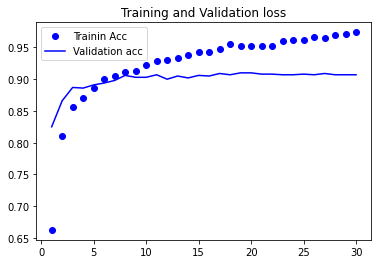

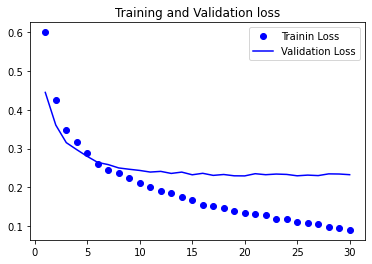

In [41]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Trainin Acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation loss')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Trainin Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Conseguimos una exactitud de validacion del 90%, mucho mejor que la que habiamos conseguido en la seccion anterior con el modelo chico entrenado desde 0.as_integer_ratio. Pero los graficos tambien indican que estamos sobreajustando casi desde el principio, pese a utilizar dropout con una tasa alta. Esto se debe a que esta tecnica no usa aumento de datos.

### EXTRACCION DE CARACTERISTICAS CON AUMENTO DE DATOS

Esta tecnica es mas lenta y cara pero permite usar el aumento de datos durante el entrenamiento: amplia el modelo conv_base y lo ejecuta de principio a fin en las entradas


Puesto que los modelos se comportan como capas podemos agregar un modelo (como conv_base) a un modelo Sequential del mismo modo en que agregamos una capa.

In [7]:
model1=models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(1,activation='sigmoid'))


In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


La base convolucional de VGG16 tiene 14.712.688 parametros, lo cual es mucho. El clasificador que agregamos encima tiene 2 millones de parametros.

Antes de compilar y entrenar el modelo, es muy importante congelar la base convolucional. **CONGELAR** una capa o conjunto de capas significa evitar que sus pesos se actualicen durante el entrenamiento. Si no lo hacemos, las representaciones aprendidas con anterioridad por la base convolucional se modificaran durante el entrenamiento. Puesto que las capas  Dense, en la parte superior se inicializan de manera aleatoria, las actualizaciones de pesos muy grandes se propagarian por toda la red, destruyendo de forma efectiva las representaciones aprendidas anteriormente.

En keras para congelar una red tenemos que configurar su atributo trainable como false:

In [9]:
print('This is the number of trainable weights before freezing the conv_base:',len(model1.trainable_weights))

This is the number of trainable weights before freezing the conv_base: 30


In [10]:
conv_base.trainable=False
print('This is the number of trainable weight after freezing the conv_base',len(model1.trainable_weights))

This is the number of trainable weight after freezing the conv_base 4


Con esta configuracion soolo se entrenara los pesos de las 2 capas Dense que hemos agregado. Eso hace un total de 4 tensores de peso: dos por capa(la matriz de peso principal y el vector de sesgo). Tenga en cuenta que para que estos cambios surtan efecto, primero hay que compilar el modelo. Si modificamos la capacidad de entrenamiento de los pesos tras la compilacion, entonces deberiamos volver a compilar el modelo, o esos cambios se ignoraran.
Ahora empecemos a entrenar el modelo, con la misma configuracion de aumento de datos que hemos utilizado en el ejemplo anterior.

Entrenemos el modelo de extremo a extremo con una base convolucional congelada.

In [11]:
#instanciamos la clase ImageDataGenerator definiendo las transformaciones que deseamos realizar sobre las imagenes.
train_datagen=ImageDataGenerator(rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

In [12]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
validation_generator=test_datagen.flow_from_directory(validation_dir,target_size=(150,150),batch_size=20,class_mode='binary')

Found 1000 images belonging to 2 classes.


In [15]:
#compilamos el modelo
model1.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=2e-5),metrics=['acc'])

In [16]:
model1.fit(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 115s 1s/step - loss: 0.5821 - acc: 0.7045 - val_loss: 0.4457 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 106s 1s/step - loss: 0.4697 - acc: 0.7935 - val_loss: 0.3714 - val_acc: 0.8520
Epoch 3/30
100/100 [==============================] - 105s 1s/step - loss: 0.4240 - acc: 0.8105 - val_loss: 0.3317 - val_acc: 0.8580
Epoch 4/30
100/100 [==============================] - 106s 1s/step - loss: 0.3923 - acc: 0.8265 - val_loss: 0.3081 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 107s 1s/step - loss: 0.3939 - acc: 0.8225 - val_loss: 0.2988 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 116s 1s/step - loss: 0.3705 - acc: 0.8335 - val_loss: 0.2875 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 106s 1s/step - loss: 0.3518 - acc: 0.8390 - val_loss: 0.2798 - val_acc: 0.8850
Epoch 8/30
100/100 [==============================] - 105s 1s/step - 

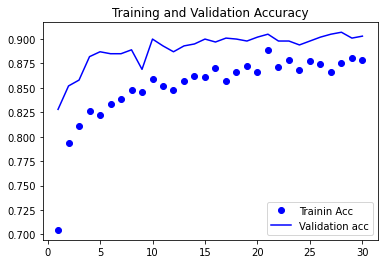

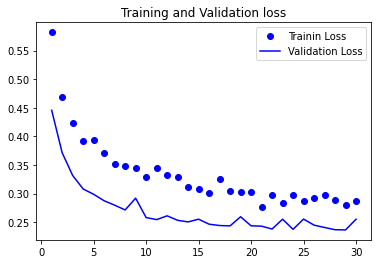

In [18]:
import matplotlib.pyplot as plt

acc=model1.history.history['acc']
val_acc=model1.history.history['val_acc']
loss=model1.history.history['loss']
val_loss=model1.history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Trainin Acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Trainin Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Como vemos logramos una exactitud cercana al 91%  que es mucho mejor que lo que obteniamos con una convnet entrenada de 0.